# Peakfinder

## Introduction

This notebook takes input data from ASR-recordings in the form of an input folder with subfolders for each animal that contain their respective CSV files and outputs information regarding the average reaction of each animal to each experiment. <br>The code is annotated and a more extensive explanation is contained within `Protocol.md`. <br>The expected time it takes to run this notebook is roughly 3-4 Minutes, but this can be shorter or longer depending on your hardware.

## Imports

If this is your first time running this, you need to install various python packages using pip. <br>
Open the terminal, either the windows command console or the VSC terminal, and run the following commands: <br>
- pip install pandas
- pip install matplotlib
- pip install numpy
- pip install ipython <br>

For the second notebook, you will also need the following:
- pip install seaborn
- pip install scipy.stats

In [7]:
import pandas as pd       
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import defaultdict
import csv
from IPython.display import clear_output

## Configuration

In [8]:
input_dir = "2025" # folder containing folder with .CSV files; subfolders are treated as animal numbers, files within them are treated as runs

output_dir = "Output" # folder containing final results

normalize = True # adjusts all values to be positive

verbose = False  # enables more output messages which can help identify problems; will only return errors if False

excel_output = True # save results as excel files; will return CSV files if False

use_RMS = True # use RMS instead of raw strength

discard_late = True # discard late peaks from final output

discard_low = True # discard low peaks from final output

example_number = 0 # index of the trial used for the example plot

thresholds = [30, 25, 20, 15] # thresholds within which a peak is seen as significant

hard_threshold = 15 # if a peak is picked up below this, it will be counted as being too low 
                    # setting this to anything other than the lowest threshold should not be necessary unless you wish to see how many peaks
                    # land between the lowest threshold and the hard threshold

time_threshold = 50 # if a peak happens this many miliseconds after the startle, it will be counted as being too late

length = 1000 # length of the time window in which to look for peaks

In [9]:
# if there are multiple startles in one experiment, write their timestamps as a list
startle_times = {

    # new

    "ASR_control": 10000,
    "gap_depth": 10100,
    "gap_duration_10": 10060,
    "gap_duration_20": 10070,
    "gap_duration_4": 10054,
    "gap_duration_50": 10100,
    "gap_duration_8": 10058,
    "offset_ASR": 10010,
    "offset_PPI_10": 10010,
    "offset_PPI_12": 10012,
    "offset_PPI_14": 10014,
    "offset_PPI_16": 10016,
    "offset_PPI_18": 10018,
    "offset_PPI_20": 10020,
    "offset_PPI_4": 10004,
    "offset_PPI_6": 10006,
    "offset_PPI_8": 10008,
    "offset_PPI_50": 10050,
    "tone_in_noise": 10100,
    

    # old

    "ClassicalPrePulse": 60000,
    "Control_Startle": 10000,
    
    "DEPTH_50%": [1000, 21020],
    "DEPTH_75%": [1000, 21020],

    "Gap_PrePulse": 60000,
    
    "GAP10_50interval": [1000, 21020], 
    "GAP20_50interval": [1000, 21020], 
    "GAP30_50interval": [1000, 21020],
    "GAP4_50interval": [1000, 21020],
    "GAP40_50interval": [1000, 21020],
    "ISI100_duration50": [1000, 21020],
    "ISI150_duration50": [1000, 21020],
    "ISI20_duration50": [1000, 21020],
    "ISI50_duration50": [1000, 21020],

    "NoiseOffset_10ms": 10000, 
    "NoiseOffset_12ms": 10000, 
    "NoiseOffset_14ms": 10000, 
    "NoiseOffset_4ms": 10000, 
    "NoiseOffset_6ms": 10000,
    "NoiseOffset_8ms": 10000,
    "NoiseOffset_PrePulse": 10000,
    "NORMAL_PPI_100": 970,
    "NORMAL_PPI_20": 1000,
    "NORMAL_PPI_50": 1000,
    "NORMAL_PPL": 1000,

    "OFFSET_10": [1000, 21020],
    "OFFSET_12": [1000, 21020],
    "OFFSET_14": [1000, 21020],
    "OFFSET_16": [1000, 21020],
    "OFFSET_4": [1000, 21020],
    "OFFSET_6": [1000, 21020],
    "OFFSET_8": [1000, 21020]
    } 

if verbose: print(f"Raw startle times: {startle_times}")

for key, entry in startle_times.items():
    if isinstance(entry, list):
        entry[1] = entry[1] - 2*(entry[0] + length) # correct second startle time in dual recordings


if verbose: print(f"Adjusted startle times: {startle_times}")

In [10]:
# CSV file settings
data_start = 5 # row where the data starts

experiment_column = 8   # column "Exp. No."
number_column = 18      # column "TrialNo"
name_column = 17        # column "Trial"
time_column = 19        # column "MS"
value_column = 20       # column "ValueG"

# adjust columns to be 0-indexed
experiment_column, number_column, name_column, time_column, value_column = (x - 1 for x in (experiment_column, number_column, name_column, time_column, value_column))

## Slicing

In [11]:
segments = {}
startles = {}

backslash = "\\"

# Loop through the directory and subdirectories to find all CSV files
for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.endswith('.csv') or file.endswith('.CSV'):

            # Construct the full file path and read the CSV
            file_path = os.path.join(root, file)
            df = pd.read_csv(file_path, low_memory=False, skiprows=[0, 2])
            
            # Initialize per-file variables
            current_segment = []
            previous_trial = None
            repetition = {}  
            segment_time = 0

            # Iterate over the rows in the dataframe
            for idx, row in df.iterrows():

                current_trial = row.iloc[name_column]

                # if the trial changes, make a cut behind the current row and save that as a segment
                if previous_trial is not None and current_trial != previous_trial: 
                    if previous_trial not in repetition: # save the mount of times we have encountered this trial type for naming
                        repetition[previous_trial] = 1
                    else:
                        repetition[previous_trial] += 1
                        
                    segment_df = pd.DataFrame(current_segment)
                    
                    # Handle the case of two startles in one trial
                    if isinstance(startle_times[previous_trial], list):
                        segment_startle = startle_times[previous_trial][0] # read out where the startle was for this segment from the dictionary
                        segment_name = f"Animal{str(root).split(backslash)[-1]}_Run{file[:-4]}_{previous_trial}_Rep{repetition[previous_trial]}_Startle1"

                        startles[segment_name] = segment_startle # save the startle of this segment in a way that names it after the segment for later

                        split_index = segment_startle + length # split by default one second after the first startle

                        first_half = segment_df.iloc[:split_index].copy().reset_index(drop=True)
                        second_half = segment_df.iloc[split_index:].copy().reset_index(drop=True)

                        second_half[0] = second_half[0] - second_half[0].iloc[0] # reset the time (column 0) 

                        segments[segment_name] = first_half 

                        if verbose: print(f"Processed {segment_name}.")

                        segment_startle = startle_times[previous_trial][1]
                        segment_name = f"Animal{str(root).split(backslash)[-1]}_Run{file[:-4]}_{previous_trial}_Rep{repetition[previous_trial]}_Startle2"

                        startles[segment_name] = segment_startle # save the startle of this segment in a way that names it after the segment for later

                        segments[segment_name] = second_half 

                        if verbose: print(f"Processed {segment_name}.")

                    # Handle the case of one startle in one trial
                    else:
                        segment_startle = startle_times[previous_trial] # read out where the startle was for this segment from the dictionary
                        segment_name = f"Animal{str(root).split(backslash)[-1]}_Run{file[:-4]}_{previous_trial}_Rep{repetition[previous_trial]}" 
                        segments[segment_name] = segment_df # save segment by name
                        startles[segment_name] = segment_startle # save the startle of this segment in a way that names it after the segment for later
                        if verbose: print(f"Processed {segment_name}.")

                    current_segment = []
                    segment_time = 0


                # Append the row to the current segment
                if normalize:
                    current_segment.append([segment_time, float(abs(pd.to_numeric(row.iloc[value_column], errors='coerce')))]) # make values positive
                else:
                    current_segment.append([segment_time, float(row.iloc[value_column])])
                
                # Proceed a step in both trial and time
                previous_trial = current_trial
                segment_time += 2 # 2 ms time intervals

            # Save the last segment
            if current_segment:
                if previous_trial not in repetition:
                    repetition[previous_trial] = 1
                else:
                    repetition[previous_trial] += 1
                    
                segment_df = pd.DataFrame(current_segment)
                if isinstance(startle_times[previous_trial], list):
                    segment_startle = startle_times[previous_trial][0]
                    segment_name = f"Animal{str(root).split(backslash)[-1]}_Run{file[:-4]}_{previous_trial}_Rep{repetition[previous_trial]}_Startle1"

                    startles[segment_name] = segment_startle

                    split_index = segment_startle + length 

                    first_half = segment_df.iloc[:split_index].copy().reset_index(drop=True)
                    second_half = segment_df.iloc[split_index:].copy().reset_index(drop=True)

                    second_half[0] = second_half[0] - second_half[0].iloc[0]

                    segments[segment_name] = first_half 

                    if verbose: print(f"Processed {segment_name}.")

                    segment_startle = startle_times[previous_trial][1]
                    segment_name = f"Animal{str(root).split(backslash)[-1]}_Run{file[:-4]}_{previous_trial}_Rep{repetition[previous_trial]}_Startle2"

                    startles[segment_name] = segment_startle

                    segments[segment_name] = second_half 

                    if verbose: print(f"Processed {segment_name}.")

                else:
                    segment_startle = startle_times[previous_trial]
                    segment_name = f"Animal{str(root).split(backslash)[-1]}_Run{file[:-4]}_{previous_trial}_Rep{repetition[previous_trial]}" 
                    segments[segment_name] = segment_df 
                    startles[segment_name] = segment_startle
                    if verbose: print(f"Processed {segment_name}.")

# Print results
clear_output(wait=False)
key_names = ', '.join(segments.keys())
length = len(segments)
if verbose: print(f"\nCreated {length} entries:\n{key_names}")

In [12]:
# Cut the segments
adjusted_segments = {}
for entry in segments:
    df = segments[entry]
    reference_time = startles[entry]  

    # Filter the data to get rows within the 1000 ms before and after the reference time
    start_time = reference_time - length
    end_time = reference_time + length

    # Filter the dataframe to include only the data within the time range
    filtered_df = df[(df.iloc[:, 0] >= start_time) & (df.iloc[:, 0] <= end_time)]

    # Adjust the time column to set the reference time to 0
    filtered_df.iloc[:, 0] = filtered_df.iloc[:, 0] - reference_time

    filtered_df.reset_index(drop=True, inplace=True) 

    adjusted_segments[entry] = filtered_df

    if verbose: print(f"Adjusted {entry}.")

C:\Users\1kolb\AppData\Local\Temp\ipykernel_5880\1476815593.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.iloc[:, 0] = filtered_df.iloc[:, 0] - reference_time


## Plotting

In [13]:
def plot_segments(name, segments, startles, threshold, adjust=True, hard=False):

    if adjust: # make the x-axis start with the startle
        df = adjusted_segments[name]
        startle_x = 0
    else:
        df = segments[name]
        startle_x = startles[name]

    median = np.median(df[1])
    

    if hard: # use hard or median threshold
        plot_threshold = threshold
    else:
        plot_threshold = threshold * median

    df = df.iloc[::2]  # only use every n-th value for plotting

    plot_title = name
    plt.figure(figsize=(8, 6))
    plt.plot(df[0], df[1], color="blue", marker="o", markersize=0)
    plt.axvline(x=startle_x, color='red', linewidth=2, linestyle='dotted', label="Startle")
    plt.axhline(y=plot_threshold, color='lime', linewidth=2, linestyle='dotted', label="Threshold")
    
    plt.xlabel("Time (ms)", fontsize=12)
    plt.ylabel("ValueG", fontsize=12)
    plt.title(plot_title, fontsize=14)

    # Adjust y-ticks to be positive (if set in configuration) and spaced correctly 
    if normalize:
        y_ticks = range(0, int(df[1].max()) + 20, 20)
    else:
        y_ticks = range(int(df[1].min()) - 20, int(df[1].max()) + 20, 20)
    plt.yticks(y_ticks)

    
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend()

    plt.show()

In [14]:
example_name =  list(adjusted_segments.keys())[example_number] # get example recording

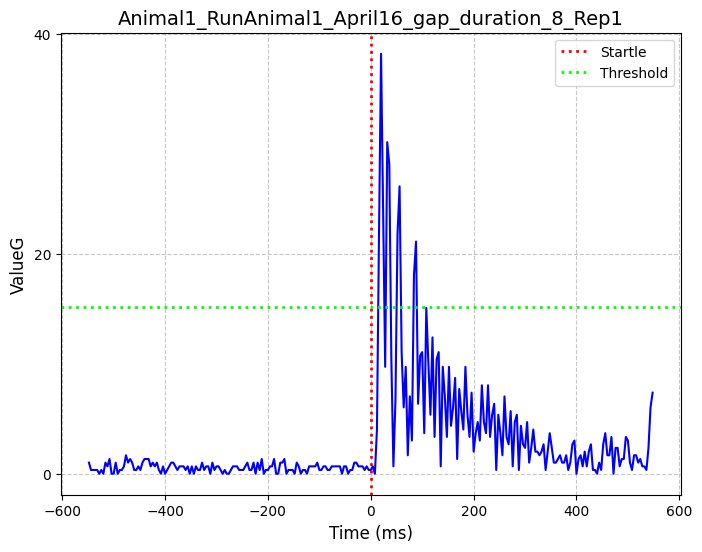

In [15]:
plot_segments(example_name, adjusted_segments, startles, threshold=15, hard=False) 

## Analysis

In [16]:
reaction = {}
no_peaks = []

toolow = []
toolate = []

for entry in adjusted_segments:
    x = 0  # reset threshold index for each entry

    while x < len(thresholds):
        times = adjusted_segments[entry][0]
        values = adjusted_segments[entry][1]

        median = np.median(values)
        median_threshold = median * thresholds[x]

        indices_above_threshold = np.where((values > median_threshold) & (times > 0))[0]

        if len(indices_above_threshold) > 0:
            peak_start = times[indices_above_threshold[0]]  # first time a value passes the threshold
            start_value = values[indices_above_threshold[0]]  # first value that passes the threshold

            min_value = min(values[indices_above_threshold])  # minimum value among those above the threshold
            min_value_index = indices_above_threshold[np.argmin(values[indices_above_threshold])]
            min_time = times[min_value_index]

            max_value = max(values[indices_above_threshold])  # maximum value among those above the threshold
            max_value_index = indices_above_threshold[np.argmax(values[indices_above_threshold])]
            max_time = times[max_value_index]

            buildup = max_time - peak_start

            if use_RMS:
                rms_value = np.sqrt(np.mean(np.square(values[indices_above_threshold]))) # calculate RMS
            else:
                rms_value = max_value  # use max_value when RMS is not needed

            if max_value >= hard_threshold: # value above threshold
                if peak_start <= time_threshold: # value within time threshold
                    reaction[entry] = {
                        "reactionTime": int(peak_start),
                        "peakTime": int(max_time),
                        "difference": int(buildup),
                        "strength (RMS)" if use_RMS else "strength (raw)": int(rms_value) 
                    }
                    if verbose: print(f"Processed {entry}.")
                else: # value outside of time threshold but within strength threshold
                    toolate.append(entry)
                    if not discard_late:
                        reaction[entry] = {
                            "reactionTime": int(peak_start),
                            "peakTime": int(max_time),
                            "difference": int(buildup),
                            "strength (RMS)" if use_RMS else "strength (raw)": int(rms_value) 
                        }
                        if verbose: print(f"Processed {entry}.")
            else: # value below strength threshold
                toolow.append(entry)
                if not discard_low:
                    reaction[entry] = {
                        "reactionTime": int(peak_start),
                        "peakTime": int(max_time),
                        "difference": int(buildup),
                        "strength (RMS)" if use_RMS else "strength (raw)": int(rms_value) 
                    }
                    if verbose: print(f"Processed {entry}.")

                if peak_start >= time_threshold: # if outside of time threshold as well, append to that list too
                    toolate.append(entry)
                    if not discard_late:
                        reaction[entry] = {
                            "reactionTime": int(peak_start),
                            "peakTime": int(max_time),
                            "difference": int(buildup),
                            "strength (RMS)" if use_RMS else "strength (raw)": int(rms_value) 
                        }
                        if verbose: print(f"Processed {entry}.")

            break

        else:
            if x == len(thresholds) - 1: # give up after trying the lowest threshold
                no_peaks.append(entry)
                if verbose: print(f"No peak found for {entry} after trying all thresholds.")
                break  
            else:
                if verbose: print(f"Lowering threshold for {entry}.")
                x += 1  # try the next lower threshold

clear_output(wait=False)
reaction = {entry: data for entry, data in reaction.items() if data["reactionTime"] <= time_threshold} # remove late peaks
if verbose: print(f"Created {len(reaction)} entries.")

# Warn if no, low or late peaks were found; these lists can help identify problems with the data or code
if no_peaks: print(f"Warning, found no peaks in {len(no_peaks)} recording(s)!")
if verbose: print(no_peaks)
if toolow: print(f"Warning, found insignificant peaks in {len(toolow)} recording(s)!")
if verbose: print(toolow)
if toolate: print(f"Warning, found late peaks in {len(toolate)} recording(s)!")
if verbose: print(toolate)

Warning, found no peaks in 47 recording(s)!


## Saving

In [17]:
grouped_data = defaultdict(lambda: {
    "reactionTime": [], "peakTime": [], "difference": [],
    "strength (raw)": [] if not use_RMS else [],
    "strength (RMS)": [] if use_RMS else []
})

# Group entries by Animal + Experiment (removing `startleX`, `RepX`, and `RunX`)
for entry, values in reaction.items():
    parts = entry.split("_")
    animal = parts[0]  # keep the animal identifier 
    
    # Remove startle, repetition, and run identifiers
    experiment = "_".join(part for part in parts[1:] if not (part.lower().startswith("startle") or part.lower().startswith("rep") or part.lower().startswith("run")))

    group_key = f"{animal}_{experiment}" # Group by animal + experiment condition

    strength_key = "strength (RMS)" if use_RMS else "strength (raw)" # set strength_key to either raw or RMS

    for key in values:
        if key == "strength (raw)" or key == "strength (RMS)":  # append to the selected strength key
            grouped_data[group_key][strength_key].append(values[key])
        else:
            grouped_data[group_key][key].append(values[key])

# Calculate averages for each animal's experiment condition
average_data = {
    group_key: {
        key: round(sum(val_list) / len(val_list), 2) if len(val_list) > 0 else None 
        for key, val_list in values.items()
    }
    for group_key, values in grouped_data.items()
}

if verbose: print(f"Created {len(average_data)} entries.")
for key, values in average_data.items():
    if verbose: print(f"{key}: {values}")

In [18]:
os.makedirs(output_dir, exist_ok=True) # create output directory if not already present

grouped_data = defaultdict(list)

for entry, values in average_data.items():
    animal, experiment = entry.split("_", 1) # split at first underscore to separate animal from experiment
    values["experiment"] = experiment # add experiment name to the values dictionary
    grouped_data[animal].append(values) # append to the animal group

# Save each animal's data into a file
for animal, experiments in grouped_data.items():
    filename = f"{animal}.xlsx" if excel_output else f"{animal}.csv"
    file_path = os.path.join(output_dir, filename)

    column_order = ["experiment"] + [key for key in experiments[0] if key != "experiment"] # set "Experiment" as the first column

    if excel_output:
        df = pd.DataFrame(experiments, columns=column_order)
        
        df = df.dropna(axis=1, how='all') # drop empty columns (either "Strength" or "Strength (RMS)"" depending on which is selected)
        
        df.to_excel(file_path, index=False)
        
    else: # option for saving as CSV
        with open(file_path, mode="w", newline="") as file:
            writer = csv.DictWriter(file, fieldnames=column_order)
            writer.writeheader()
            writer.writerows(experiments)

    if verbose: print(f"Saved {filename}")

## Debugging

In [19]:
# Print out all lists containing faulty peaks; adjust as needed
if no_peaks: 
    print(f"Found no peaks in {len(no_peaks)} recording(s):")
    print(no_peaks)
if toolow:
    print(f"Found insignificant peaks in {len(toolow)} recording(s):")
    print(toolow)
if toolate:
    print(f"Found late peaks in {len(toolate)} recording(s):")
    print(toolate)

Found no peaks in 47 recording(s):
['Animal1_RunAnimal1_April16_offset_ASR_Rep1', 'Animal1_RunAnimal1_April16_offset_ASR_Rep2', 'Animal1_RunAnimal1_April16_offset_ASR_Rep3', 'Animal1_RunAnimal1_April16_offset_ASR_Rep4', 'Animal1_RunAnimal1_April16_offset_PPI_8_Rep4', 'Animal1_RunAnimal1_April16_offset_PPI_8_Rep5', 'Animal1_RunAnimal1_April16_offset_ASR_Rep5', 'Animal1_RunAnimal1_April16_tone_in_noise_Rep4', 'Animal10_RunAnimal10_April16_offset_ASR_Rep1', 'Animal10_RunAnimal10_April16_offset_ASR_Rep2', 'Animal10_RunAnimal10_April16_offset_ASR_Rep3', 'Animal10_RunAnimal10_April16_offset_ASR_Rep4', 'Animal10_RunAnimal10_April16_offset_ASR_Rep5', 'Animal15_RunAnimal15_April16_offset_ASR_Rep1', 'Animal15_RunAnimal15_April16_offset_PPI_10_Rep1', 'Animal15_RunAnimal15_April16_offset_PPI_6_Rep2', 'Animal15_RunAnimal15_April16_offset_ASR_Rep2', 'Animal15_RunAnimal15_April16_offset_PPI_10_Rep2', 'Animal15_RunAnimal15_April16_offset_PPI_16_Rep2', 'Animal15_RunAnimal15_April16_offset_PPI_18_Rep3',